# Equity Lens Survey Participation 

Simple dataset - listing of enumerators and their surveying activity

**Objective:** Py libs for data exploration and summary stats

In [57]:
%run "../utils/load_envz.ipynb"

In [2]:
# Load data set 

DATA_DIR = "../dataset"
DATA_FILE = "OG_equity_lens_pilot-20180313.csv" 

dataset = pd.read_csv( "%s/%s" % (DATA_DIR, DATA_FILE) )
                      

## Exploring the data

- Number of records and variables  =  {{ dataset.shape }}
- Variable types
- Missing data 
- Outliers 

## Data Structure

In [3]:
## " Shape of the dataset - #records, #variables"
dataset.shape

(72, 5)

In [4]:
## "Variable Data Types"
dataset.dtypes

CHP.ID                        object
Nmb.Households.Registered      int64
Nmb.HH.Done.FamilySurvey       int64
Pct.HH.Done.FamilySurvey     float64
Branch.Name                   object
dtype: object

## Missing Data and Outliers

### Missing Data 

In [5]:
## Missing data
dataset.apply( lambda x: sum(x.isnull() ), axis=0) 

CHP.ID                        0
Nmb.Households.Registered     0
Nmb.HH.Done.FamilySurvey      0
Pct.HH.Done.FamilySurvey      0
Branch.Name                  58
dtype: int64

- Branch.Name has 58 missing records. All other variables are okay. 
    - Will drop col Branch.Name. 

In [6]:
dataset.drop( "Branch.Name",axis=1, inplace=True)
dataset.dtypes

CHP.ID                        object
Nmb.Households.Registered      int64
Nmb.HH.Done.FamilySurvey       int64
Pct.HH.Done.FamilySurvey     float64
dtype: object

### Outliers
- Using distributions to identify outliers and clean up accordingly
- Plus check for normality 


C:\Users\BILHA\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Nmb.Households.Registered    AxesSubplot(0.125,0.125;0.775x0.755)
Nmb.HH.Done.FamilySurvey     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

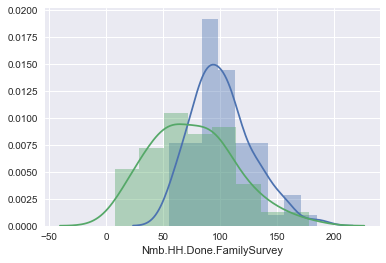

In [7]:
## We've got three numeric variable - easy to work with 
dataset.ix[:,1:3].apply( lambda x: sns.distplot(x), axis=0)  

- Doesn't look so bad for HH registration and # HH surveyed

## Calculated Fields

- There's a Pct field in there but we don't need to store such fields
    - recalculating it here and checking if it is different 
- Not much computation we can do here unless we're aggregating by some dimension
    - will random assign CHP to a trial and control group and do some aggregation

In [37]:
## Pct HHs per CHV that have done the survey << TODO: Find better libs for this, including error handling. Dplyr in R equiv
dataset["Pct.CHP.Group.HH.Surveyed"] = dataset["Nmb.HH.Done.FamilySurvey"] / dataset["Nmb.Households.Registered"]
dataset["Diffs.In.Pcts"] = np.where( dataset["Pct.CHP.Group.HH.Surveyed"] != dataset["Pct.HH.Done.FamilySurvey"], True, False) 
dataset["Diffs.In.Pcts"].value_counts()

True     61
False    11
Name: Diffs.In.Pcts, dtype: int64

In [9]:
## random view diffs 
dataset[ dataset["Diffs.In.Pcts"] == True].sample(6)

,CHP.ID,Nmb.Households.Registered,Nmb.HH.Done.FamilySurvey,Pct.HH.Done.FamilySurvey,Pct.CHP.Group.HH.Surveyed,Diffs.In.Pcts
60,CHP.Og.61,75,50,0.666667,0.666667,True
71,CHP.Og.72,105,33,0.314286,0.314286,True
68,CHP.Og.69,117,107,0.914530,0.914530,True
0,CHP.Og.1,88,47,0.534091,0.534091,True
41,CHP.Og.42,95,54,0.568421,0.568421,True
14,CHP.Og.15,85,65,0.764706,0.764706,True


- There's really no problem with the calcuations 
    - TODO: column operations fail. Fix that!! << np.where is not a fix either so not about the logic but probably about precision 
    

In [10]:
## Now lets assign groups 
dataset["TreatmentGroup"] = np.where( dataset["Nmb.HH.Done.FamilySurvey"] % 2 == 0, "Trial", "Control")
dataset["TreatmentGroup"].value_counts()

Control    37
Trial      35
Name: TreatmentGroup, dtype: int64

## Sample Structure
- number of records and by grouping levels
    - CHP as study unit
    - grouping by treatment group

In [36]:
aggz = {
    "CHP.ID" : { "# CHPs" : "count"},
    "Nmb.Households.Registered": { "# Households" : "sum", "Avg.HH Size": "mean"},
    "Nmb.HH.Done.FamilySurvey" : { "# HH Surveyed" : "sum", "Avg.HH Surveyed Size": "mean"}, 
    "Pct.CHP.Group.HH.Surveyed" : { " Avg.Pct HH Surveyed" : "mean" }
}

dataset.groupby( "TreatmentGroup", as_index=True ).agg( aggz )

C:\Users\BILHA\Anaconda3\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


CHP.ID Nmb.Households.Registered              \
               # CHPs              # Households Avg.HH Size   
TreatmentGroup                                                
Control            37                      3891  105.162162   
Trial              35                      3426   97.885714   

               Nmb.HH.Done.FamilySurvey                       \
                          # HH Surveyed Avg.HH Surveyed Size   
TreatmentGroup                                                 
Control                            3025            81.756757   
Trial                              2446            69.885714   

               Pct.CHP.Group.HH.Surveyed  
                     Avg.Pct HH Surveyed  
TreatmentGroup                            
Control                         0.774784  
Trial                           0.708241

In [12]:
gg = dataset.groupby( "TreatmentGroup").agg( { "CHP.ID": "count", "Nmb.Households.Registered": [min,max,sum, np.mean]})
gg

CHP.ID Nmb.Households.Registered                       
                count                       min  max   sum        mean
TreatmentGroup                                                        
Control            37                        55  157  3891  105.162162
Trial              35                        62  185  3426   97.885714

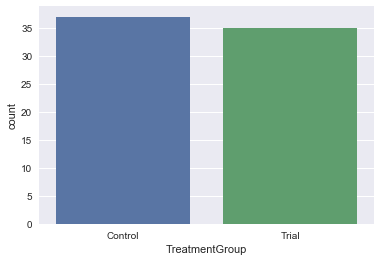

In [13]:
sns.countplot( x="TreatmentGroup", data=dataset )

In [14]:
gg.info()
# sns.barplot( gg[[[]]]) << TODO: referencing indecies in a grouped frame/pivot tables 

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, Control to Trial
Data columns (total 5 columns):
(CHP.ID, count)                      2 non-null int64
(Nmb.Households.Registered, min)     2 non-null int64
(Nmb.Households.Registered, max)     2 non-null int64
(Nmb.Households.Registered, sum)     2 non-null int64
(Nmb.Households.Registered, mean)    2 non-null float64
dtypes: float64(1), int64(4)
memory usage: 96.0+ bytes


0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

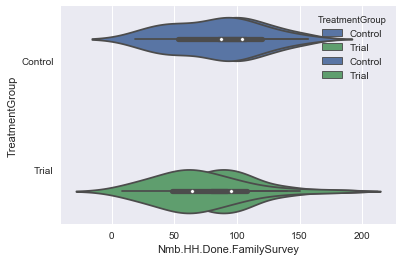

In [15]:
pd.Series(dataset.columns[1:3]).apply( lambda x: sns.violinplot( x, "TreatmentGroup", hue="TreatmentGroup", data=dataset) )
# TODO: stack it 

## Summary Stats & Statistical Tests

In [16]:
## Summarize with table and visuals  << TODO: pretty print tables 
## variable = % surveyed 

dataset.describe()

,Nmb.Households.Registered,Nmb.HH.Done.FamilySurvey,Pct.HH.Done.FamilySurvey,Pct.CHP.Group.HH.Surveyed
count,72.000000,72.000000,72.000000,72.000000
mean,101.625000,75.986111,0.742437,0.742437
std,26.696752,36.570015,0.265242,0.265242
min,55.000000,8.000000,0.076190,0.076190
25%,85.000000,50.000000,0.553840,0.553840
50%,99.000000,72.000000,0.843870,0.843870
75%,116.250000,98.250000,0.962531,0.962531
max,185.000000,178.000000,1.000000,1.000000


### 1. Ho = Trial increased survey participation 
- survey participation = % of registered households that were surveyed. 


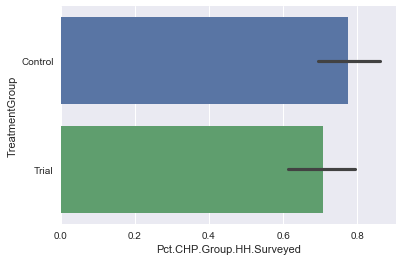

In [17]:
sns.barplot( x="Pct.CHP.Group.HH.Surveyed", y="TreatmentGroup", data=dataset ) 


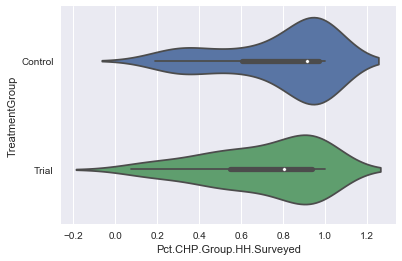

In [18]:
sns.violinplot( dataset["Pct.CHP.Group.HH.Surveyed"], dataset["TreatmentGroup"]) 

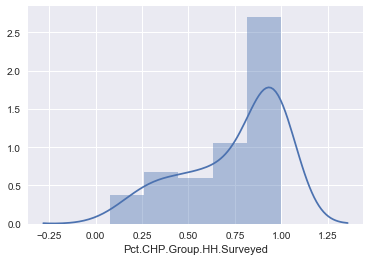

In [19]:
sns.distplot( dataset["Pct.CHP.Group.HH.Surveyed"])

## TODO: grid plots

In [20]:
## Correlations <<< TODO: wrong to correlate % to treatment??? 
dataset["Dummy.Treatment"] = np.where( dataset["TreatmentGroup"] == "Trial", 1, 0)
dataset[[ "Pct.CHP.Group.HH.Surveyed", "Dummy.Treatment", "Nmb.Households.Registered", "Nmb.HH.Done.FamilySurvey"] ].corr() 

,Pct.CHP.Group.HH.Surveyed,Dummy.Treatment,Nmb.Households.Registered,Nmb.HH.Done.FamilySurvey
Pct.CHP.Group.HH.Surveyed,1.000000,-0.126270,0.076754,0.780232
Dummy.Treatment,-0.126270,1.000000,-0.137183,-0.163382
Nmb.Households.Registered,0.076754,-0.137183,1.000000,0.666278
Nmb.HH.Done.FamilySurvey,0.780232,-0.163382,0.666278,1.000000


In [21]:
dataset[[ "Pct.CHP.Group.HH.Surveyed", "Dummy.Treatment", "Nmb.Households.Registered", "Nmb.HH.Done.FamilySurvey"] ].corr(method="spearman")

,Pct.CHP.Group.HH.Surveyed,Dummy.Treatment,Nmb.Households.Registered,Nmb.HH.Done.FamilySurvey
Pct.CHP.Group.HH.Surveyed,1.000000,-0.157217,0.028447,0.756797
Dummy.Treatment,-0.157217,1.000000,-0.172545,-0.186550
Nmb.Households.Registered,0.028447,-0.172545,1.000000,0.578699
Nmb.HH.Done.FamilySurvey,0.756797,-0.186550,0.578699,1.000000


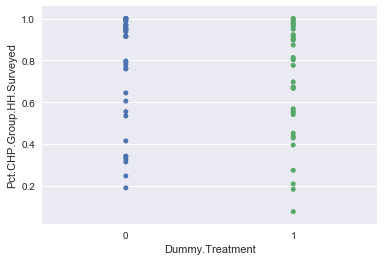

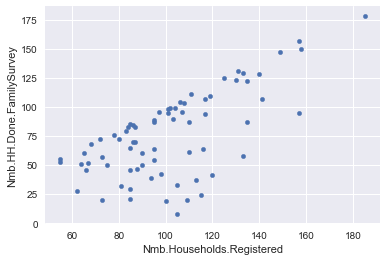

In [22]:
## scatter plotting it
sns.stripplot(x="Dummy.Treatment", y="Pct.CHP.Group.HH.Surveyed", data=dataset)  
dataset.plot.scatter( x= "Nmb.Households.Registered", y="Nmb.HH.Done.FamilySurvey")

In [23]:
%%R -i dataset
ggplot( dataset)+geom_point( aes(     

ERROR:root:Cell magic `%%R` not found.


In [73]:
smf.glm( formula="Pct.CHP.Group.HH.Surveyed ~ TreatmentGroup", data=dataset).fit()

PatsyError: Error evaluating factor: NameError: name 'Pct' is not defined
    Pct.CHP.Group.HH.Surveyed ~ TreatmentGroup
    ^^^^^^^^^^^^^^^^^^^^^^^^^

**Correlation Output** 
- Being in treatment group is negatively correlated with increased surveying rates. Treatment has decreasing surveying rates 
    - being in treatment also associated with lower 
    registraion. So it may follow that
    - magnitude is less than 0.3
    
 
- Doesn't make to correlate doing survey and being registered -- can't do survey unless you're registered, so of course they are associated. 

- Should we correlate to dummy variable?? but can regress on it so?? just do Ho: testing b/c one var so the glm = Ho t-test, si

## Statistical Tests
- Ho t-test 


In [52]:
## Using t.test methods Vs using glm methods <<< find the py equivs for R << Can't wait to get some R in here 

## Using smf on glm model 
# x,y = dmatrices( "'Pct.CHP.Group.HH.Surveyed' ~ 'TreatmentGroup'", data=dataset, return_type="dataframe")


In [63]:
## Using scipy
lm = sci.ttest_ind(dataset[dataset["Dummy.Treatment"]==1]["Pct.CHP.Group.HH.Surveyed"], dataset[dataset["Dummy.Treatment"]==0]["Pct.CHP.Group.HH.Surveyed"])
lm

Ttest_indResult(statistic=-1.0649787248863229, pvalue=0.29054532318513066)

- The two populations are not different
    - p-value = 0.29 